## Iterators and Generators

In Python, anything which can be iterated over is called an iterable:

In [1]:
bowl = {
    "apple": 5,
    "banana": 3,
    "orange": 7
}

for fruit in bowl:
    print(fruit.upper())

APPLE
BANANA
ORANGE


Surprisingly often, we want to iterate over something that takes a moderately
large amount of memory to store - for example, our map images in the
green-graph example.

Our green-graph example involved making an array of all the maps between London
and Birmingham. This kept them all in memory *at the same time*: first we
downloaded all the maps, then we counted the green pixels in each of them. 

This would NOT work if we used more points: eventually, we would run out of memory.
We need to use a **generator** instead. This chapter will look at iterators and generators in more detail:
how they work, when to use them, how to create our own.

### Iterators

Consider the basic python `range` function:

In [2]:
range(10)

range(0, 10)

In [3]:
total = 0
for x in range(int(1e6)):
    total += x

total

499999500000

In order to avoid allocating a million integers, `range` actually uses an **iterator**.

We don't actually need a million integers *at once*, just each
integer *in turn* up to a million.

Because we can get an iterator from it, we say that a range is an **iterable**.

So we can `for`-loop over it:

In [4]:
for i in range(3): 
    print(i)

0
1
2


There are two important Python built-in functions for working with iterables.
First is `iter`, which lets us create an iterator from any iterable object.

In [5]:
a = iter(range(3))

Once we have an iterator object, we can pass it to the `next` function. This
moves the iterator forward, and gives us its next element:

In [6]:
next(a)

0

In [7]:
next(a)

1

In [8]:
next(a)

2

When we are out of elements, a `StopIteration` exception is raised:

In [9]:
next(a)

StopIteration: 

This tells Python that the iteration is over. For example, if we are in a `for i in range(3)` loop, this lets us know when we should exit the loop.

We can turn an iterable or iterator into a list with the `list` constructor function:

In [10]:
list(range(5))

[0, 1, 2, 3, 4]

### Defining Our Own Iterable

When we write `next(a)`, under the hood Python tries to call the `__next__()` method of `a`. Similarly, `iter(a)` calls `a.__iter__()`.

We can make our own iterators by defining *classes* that can be used with the `next()` and `iter()` functions: this is the **iterator protocol**.

For each of the *concepts* in Python, like sequence, container, iterable, the language defines a *protocol*, a set of methods a class must implement, in order to be treated as a member of that concept.

To define an iterator, the methods that must be supported are `__next__()` and `__iter__()`.

`__next__()` must update the iterator.

We'll see why we need to define `__iter__` in a moment.

Here is an example of defining a custom iterator class:

In [11]:
class fib_iterator:
    """An iterator over part of the Fibonacci sequence."""

    def __init__(self, limit, seed1=1, seed2=1):
        self.limit = limit
        self.previous = seed1
        self.current = seed2

    def __iter__(self):
        return self

    def __next__(self):
        (self.previous, self.current) = (self.current, self.previous + self.current)
        self.limit -= 1
        if self.limit < 0:
            raise StopIteration()
        return self.current

In [12]:
x = fib_iterator(5)

In [13]:
next(x)

2

In [14]:
next(x)

3

In [15]:
next(x)

5

In [16]:
next(x)

8

In [17]:
for x in fib_iterator(5):
    print(x)

2
3
5
8
13


In [18]:
sum(fib_iterator(1000))

297924218508143360336882819981631900915673130543819759032778173440536722190488904520034508163846345539055096533885943242814978469042830417586260359446115245634668393210192357419233828310479227982326069668668250

### A shortcut to iterables: the `__iter__` method

In fact,  we don't always have to define both `__iter__` and `__next__`!

If, to be iterated over, a class just wants to behave as if it were some other iterable, you can just implement `__iter__` and return `iter(some_other_iterable)`, without implementing `next`.  For example, an image class might want to implement some metadata, but behave just as if it were just a 1-d pixel array when being iterated:

In [19]:
from numpy import array
from matplotlib import pyplot as plt


class MyImage(object):
    def __init__(self, pixels):
        self.pixels = array(pixels, dtype='uint8')
        self.channels = self.pixels.shape[2]

    def __iter__(self):
        # return an iterator over just the pixel values
        return iter(self.pixels.reshape(-1, self.channels))

    def show(self):
        plt.imshow(self.pixels, interpolation="None")


x = [[[255, 255, 0], [0, 255, 0]], [[0, 0, 255], [255, 255, 255]]]
image = MyImage(x)

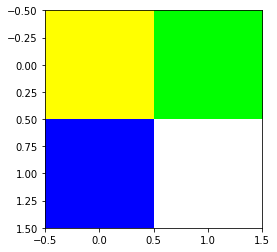

In [20]:
%matplotlib inline
image.show()

In [21]:
image.channels

3

In [22]:
from webcolors import rgb_to_name
for pixel in image:
    print(rgb_to_name(pixel))

yellow
lime
blue
white


See how we used `image` in a `for` loop, even though it doesn't satisfy the iterator protocol (we didn't define both `__iter__` and `__next__` for it)?

The key here is that we can use any *iterable* object (like `image`) in a `for` expression,
not just iterators! Internally, Python will create an iterator from the iterable (by calling its `__iter__` method), but this means we don't need to define a `__next__` method explicitly.

The *iterator* protocol is to implement both `__iter__` and
`__next__`, while the *iterable* protocol is to implement `__iter__` and return
an iterator.

### Generators

There's a fair amount of "boiler-plate" in the above class-based definition of
an iterable.

Python provides another way to specify something
which meets the iterator protocol: **generators**.

In [23]:
def my_generator():
    yield 5
    yield 10


x = my_generator()

In [24]:
next(x)

5

In [25]:
next(x)

10

In [26]:
next(x)

StopIteration: 

In [27]:
for a in my_generator():
    print(a)

5
10


In [28]:
sum(my_generator())

15

A function which has `yield` statements instead of a `return` statement returns
**temporarily**: it automagically becomes something which implements `__next__`.

Each call of `next()` returns control to the function where it
left off.

 Control passes back-and-forth between the generator and the caller.
Our Fibonacci example therefore becomes a function rather than a class.

In [29]:
def yield_fibs(limit, seed1=1, seed2=1):
    current = seed1
    previous = seed2

    while limit > 0:
        limit -= 1
        current, previous = current + previous, current
        yield current

We can now use the output of the function like a normal iterable:

In [30]:
sum(yield_fibs(5))

31

In [31]:
for a in yield_fibs(10):
    if a % 2 == 0:
        print(a)

2
8
34
144


Sometimes we may need to gather all values from a generator into a list, such as before passing them to a function that expects a list:

In [32]:
list(yield_fibs(10))

[2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

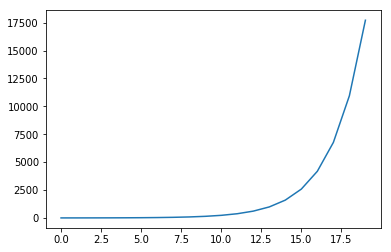

In [33]:
plt.plot(list(yield_fibs(20)))

## Related Concepts

Iterables and generators can be used to achieve complex behaviour, especially when combined with functional programming. In fact, Python itself contains some very useful language features that make use of these practices: context managers and decorators. We have already seen these in this class, but here we discuss them in more detail.

### Context managers

[We have seen before](../ch01data/060files.html#Closing-files) [[notebook](../ch01data/060files.ipynb#Closing-files)] that, instead of separately `open`ing and `close`ing a file, we can have
the file be automatically closed using a context manager:

In [34]:
%%writefile example.yaml
modelname: brilliant

Writing example.yaml


In [35]:
import yaml

with open('example.yaml') as foo:
    print(yaml.load(foo))

{'modelname': 'brilliant'}


In addition to more convenient syntax, this takes care of any clean-up that has to be done after the file is closed, even if any errors occur while we are working on the file.




How could we define our own one of these, if we too have clean-up code we
always want to run after a calling function has done its work, or set-up code
we want to do first?

We can define a class that meets an appropriate protocol:




In [36]:
class verbose_context():
    def __init__(self, name):
        self.name=name
    def __enter__(self):
        print("Get ready, ", self.name)
    def __exit__(self, exc_type, exc_value, traceback):
        print("OK, done")

with verbose_context("Monty"):
    print("Doing it!")

Get ready,  Monty
Doing it!
OK, done




However, this is pretty verbose! Again, a generator with `yield` makes for an easier syntax:




In [37]:
from contextlib import contextmanager

@contextmanager
def verbose_context(name):
    print("Get ready for action, ", name)
    yield name.upper()
    print("You did it")

with verbose_context("Monty") as shouty:
    print(f"Doing it, {shouty}")

Get ready for action,  Monty
Doing it,  MONTY
You did it




Again, we use `yield` to temporarily return from a function.


### Decorators


When doing functional programming, we may often want to define mutator
functions which take in one function and return a new function, such as our
derivative example earlier.




In [38]:
from math import sqrt


def repeater(count):
    def wrap_function_in_repeat(func):

        def _repeated(x):
            counter = count
            while counter > 0:
                counter -= 1
                x = func(x)
            return x

        return _repeated
    return wrap_function_in_repeat


fiftytimes = repeater(50)

fiftyroots = fiftytimes(sqrt)

print(fiftyroots(100))

1.000000000000004


It turns out that, quite often, we want to apply one of these to a function as we're defining a class.
For example, we may want to specify that after certain methods are called, data should always be stored:

Any function which accepts a function as its first argument and returns a function can be used as a **decorator** like this.

Much of Python's standard functionality is implemented as decorators: we've
seen @contextmanager, @classmethod and @attribute. The @contextmanager
metafunction, for example, takes in an iterator, and yields a class conforming
to the context manager protocol.


In [39]:
@repeater(3)
def hello(name):
    return f"Hello, {name}"

In [40]:
hello("Cleese")

'Hello, Hello, Hello, Cleese'

## Supplementary material

The remainder of this page contains an example of the flexibility of the features discussed above. Specifically, it shows how generators and context managers can be combined to create a testing framework like the one previously seen in the course.

### Test generators


A few weeks ago we saw a test which loaded its test cases from a YAML file and
asserted each input with each output. This was nice and concise, but had one
flaw: we had just one test, covering all the fixtures, so we got just one . in
the test output when we ran the tests, and if any test failed, the rest were
not run. We can do a nicer job with a test **generator**:





In [41]:
def assert_exemplar(**fixture):
    answer = fixture.pop('answer')
    assert_equal(greet(**fixture), answer)


def test_greeter():
    with open(os.path.join(os.path.dirname(
        __file__), 'fixtures', 'samples.yaml')
    ) as fixtures_file:
        fixtures = yaml.load(fixtures_file)

        for fixture in fixtures:

            yield assert_exemplar(**fixture)

Each time a function beginning with `test_` does a `yield` it results in another test.

### Negative test contexts managers

We have seen this:

In [42]:
from pytest import raises

with raises(AttributeError):
    x = 2
    x.foo()

We can now see how `pytest` might have implemented this:

In [43]:
from contextlib import contextmanager


@contextmanager
def reimplement_raises(exception):
    try:
        yield
    except exception:
        pass
    else:
        raise Exception("Expected,", exception,
                        " to be raised, nothing was.")

In [44]:
with reimplement_raises(AttributeError):
    x = 2
    x.foo()

### Negative test decorators

Some frameworks, like `nose`, also implement a very nice negative test decorator, which lets us marks tests that we know should produce an exception:

In [45]:
import nose


@nose.tools.raises(TypeError, ValueError)
def test_raises_type_error():
    raise TypeError("This test passes")

In [46]:
test_raises_type_error()

In [47]:
@nose.tools.raises(Exception)
def test_that_fails_by_passing():
    pass

In [48]:
test_that_fails_by_passing()

AssertionError: test_that_fails_by_passing() did not raise Exception

We could reimplement this ourselves now too, using the context manager we wrote above:

In [49]:
def homemade_raises_decorator(exception):
    def wrap_function(func):  # Closure over exception
        # Define a function which runs another function under our "raises" context:
        def _output(*args):  # Closure over func and exception
            with reimplement_raises(exception):
                func(*args)
        # Return it
        return _output
    return wrap_function

In [50]:
@homemade_raises_decorator(TypeError)
def test_raises_type_error():
    raise TypeError("This test passes")

In [51]:
test_raises_type_error()